# Practical Aspects of Scientific Computing

> Your time is more valuable than computer time.

We discuss several aspects of computing that are things you do but don't often think about.  They can potentially save a large amount of time for you (and maybe your computer).  In particular, we are going to look at

* **Versioning** -- maintaining a consistent set of code with history
* **Style** -- how you write your code influences its legibility
* **Debugging** -- finding and fixing problems in your code
* **Structure** -- how your code is organized
* **Data** -- what you do with data / keeping data safe
* **Visualization** -- viewing your final product most effectively

# ======== Versioning ========

Hard drive space is cheap.  As you work, keep track of changes and help others work with you on your project.  One of the easy ways to do this is by using a Version Control System (VCS).  Popular ones include:

* **git** -- made by Linus T., distributed, light-weight branching, GitHub
* **hg** -- mercurial, similar to git, subversion also popular
* **SVN** -- subversion, older, was very popular
* **CVS** -- older, branching is a little harder

Let's look a bit at *git*.  Git is a distributed version control system where each member has a full code history.  Each time a change is made, it is inserted into the history as a *commit*.  These commits can be grouped into larger structures known as *branches* which are off-shoot from a particular point in time.  They often contain a particular feature implementation or a bug fix. The simplest workflow for a single branch, single developer is this:

    git clone <resource-url>
    < edit some files >
    git add < file names >
    git commit -m "an informative message about what you did"
    git push origin master

I am personally a big fan of [this workflow](http://nvie.com/posts/a-successful-git-branching-model/) which maintains a release oriented `master` branch, a `develop` branch which has active development, and `feature` branches for larger changes.  Additionally, this workflow includes `--no-ff` which keeps full branch history around after merges happen. That is, when done with a feature branch:

    git checkout -b feature
    < make some changes >
    git add <files>
    git commit -m "good, descriptive message"

    git checkout develop
    git merge --no-ff feature
    git branch -d feature
    git push origin develop
    

When working along a single branch I recommend the rebase workflow to allow for easier bisecting to find bugs.  In particular, when working with more than one developer, you may find that they have incorporated changes in between your syncs (via `fetch` or `pull`).  To remedy this, I personally do:

    git push origin master
         ![rejected] (someone else has pushed and you are not synced)
         
    git fetch origin
    git rebase origin/master
    git push origin master

This keeps the history mostly linear and makes it easier to track changes.

![](git-branches.png)

# ======== Style ========

Being able to sit down and understand a code base quickly is important.  To make sure you play well with others, style is important.  Different companies, languages, and individuals have preferred styles.  Python is nice in that there is a well-defined style guide that everyone can use: [PEP8](https://www.python.org/dev/peps/pep-0008/). Some of the suggestions are a little out-dated so take with a grain of salt, but here are a few key points about formatting -

* Spaces are preferred (4 to a tab)
* Shorter lines are easier to read (when completed correctly)
* Avoid extra whitespace
* No bare `except`s

Naming conventions 
* **`CamelCase`** for classes
* **`underscore_lowercase`** for functions and variables (`mixedCase` okay if prevailing style)
* **`oneword`** for modules
* **`CAPITAL_WORDS`** for constants

Comments
* `"""` blockquotes for docstrings
* `#` for multiline and (occasional) inline comments

Also, it is important to stay 'Pythonic'. Prefer list / dictionary comprehensions for shorter statements, keep ideas separated using whitespace.  Comment in blocks unless necessary. Use parallel structure in code when it is necessary. For example, consider the following three code blocks (NOTE, I did not check to make sure these work):

In [1]:
def lowpass_filter_3d(field, freq_cutoff):
    """
    Performs a low-pass filter on 3D `ndarray`, removing frequencies
    higher than `freq_cutoff` where a frequency is defined by `np.fft.fftfreq`
    
    Parameters:
    -----------
        field : 3D ndarray [M,N,P]
            The field which we wish to perform the filter on, has 3 dimensions
            
        freq_cutoff : float
            Hard frequency cutoff for the filter, frequencies are defined by
            the FFT standard implemented in `np.fft.fftfreq`
    
    Returns:
    --------
        filtered_field : 3d ndarray [M,N,P]
            The filtered, real-space field after applying the low-pass filter
            
    Examples:
    
    arr = np.random.rand((32,32,32))
    lowpass_filter_3d(np.random.rand(arr, 0.3))
    """
    # take the FFT of the incoming data
    qfield = np.fft.fftn(field)

    # build an array of frequencies for each axis dimension,
    # broadcast them using a meshgrid, then take the norm along the last axis
    kval = [np.fft.fftfreq(i) for i in field.shape]
    kvec = np.array(np.meshgrid(*kval, indexing='ij'))
    klen = np.sqrt((kvec**2).sum(axis=0))

    # zero the frequencies beyond our cutoff, inverse FFT and real part
    qfield[klen > freq_cutoff] = 0
    return np.real(np.fft.ifftn(qfield))

def LowpassFilter3d(i, freq):
    """ Perform low pass filter """
    a = np.fft.fftn(i) # take the FFT of our data
    kx, ky, kz = np.fft.fftfreq(a.shape[0]), np.fft.fftfreq(a.shape[1]), np.fft.fftfreq(a.shape[2]) # create the kvectors for this particular array shape
    k = np.sqrt(kx[:,None,None]**2 + ky[None,:,None]**2 + kz[None,None,:]**2)
    qout = np.where(k > freq, [np.zeros_like(k), qfield])
    rout = np.real(np.fft.ifftn(qout))
    return rout

def lowpass_filter_3d(field, freq_cutoff):
    """ low pass filter
    """
    # take the fftn of the field
    qfield = np.fft.fftn(field)

    # create the kx array
    kx = np.fft.fftfreq(a.shape[0])
    
    # create the ky array
    ky = np.fft.fftfreq(a.shape[1])
    
    # create the kz array
    kz = np.fft.fftfreq(a.shape[2])
    
    # create the length of the frequency vector
    klen = np.sqrt(kx[:,None,None]**2 + ky[None,:,None]**2 + 
        kz[None,None,:]**2)

    # zero the frequencies beyond our cutoff, inverse FFT and real part
    qfield[klen > freq_cutoff] = 0
    out = np.real(np.fft.ifftn(qfield))
    # return the result
    return out

#### Version 1:

* Clear documentation string showing usage and describing inputs / outputs
* Separates ideas clearly: (a) Go to Fourier space (b) calculate k-vectors (c) apply filter (d) return to real-space
* Comments are clear and describe not what happens, but strange decisions made in the code
* Not very hard coded, list comprehension

#### Version 2:

* Un-readable, lines too long, no grouping of ideas
* Obscure functions where readable options exist

#### Version 3:

* Does not utilize whitespace well
* Comments don't actually say anything, just repeating code
* Tries to shorten lines but loses clarity in doing so (which function is already closed?)

# ======== Debugging ========

One of the most common things you do when creating a software package or solving a science problem is to debug your code.  I'm taking 'debug' in the sense of removing problems from your code.  So the natural place to begin is: how do you find bugs?

## Finding bugs, testing code

While the most natural way to find problems is to allow them to surface, this is not always the best practice.  Direct visualization will often reveal problems since we are quite good at recognizing visual patterns.  Some issues are more subtle than you'd expect / appreciate at first glance.  That is why some people advocate for *test-driven* development. In this paradigm, you must write a battery of tests that cover the entire functionality of the code base.  

#### Example: chaotic scattering

Chaos is very generic property of dynamical systems usually characterized by sensitivity to initial conditions, topological mixing, and many dense periodic orbits.  For example if you consider the path of light through a set of reflective balls, the trajectory of the light is very complex due to the non-analytic edges of the objects.  The image from such a setup creates a real-space fractal as seen below.  In fact, each color in the picture touches every other color even at their boundary (?!).

![](wada2.jpg)

Christmas ball fractal (src: http://www.evilmadscientist.com/2006/christmas-chaos/)

To study this system, we essentially need to propogate light by finding the intersection of lines and circles (for the 2D case).  Such a function may look like:

In [2]:
import matplotlib.pylab as pl
import numpy as np
import scipy as sp
%matplotlib inline

def sgn(a):
    """
    Return the sign of the argument (in contrast to np.sign)
        -1 if a < 0
        +1 if a >= 0
        
    Parameters:
    -----------
        a : int, float
            the argument to check
    
    Examples:
    
    >>> sgn(-1)
    -1.0
    
    >>> sgn(0)
    1.0

    >>> sgn(1e9)
    1.0
    """
    return -1.0*(a < 0) + 1.0*(a >= 0)

def intersection_line_circle(pt0, pt1, radius):
    """
    Find the intersection between line defined by points pt0 and pt1
    and a circle of size radius at the origin (0,0) given by quadratic
    solution (see http://mathworld.wolfram.com/Circle-LineIntersection.html).
    
    Parameters:
    -----------
        pt0 : array_like -> [2]
            Beginning point for line of the form [x,y]

        pt1 : array_like -> [2]
            End point for line of the form [x,y]

        radius : float
            The radius of the circle at the origin (0,0) to intersect

    Returns:
    --------
        intersection : array_like
            A list of the intersections for the line with the circle,
            Can be as large as [2,2] and small as empty.  If no intersections,
            will return empty list.  Two intersections will be returned
            in the form [[x1, y1], [x2, y2]]

    Note: since this is example code, I will not be respecting floating-point
          issues introduced by loss of significance by quadratic formula
          (see https://en.wikipedia.org/wiki/Loss_of_significance)

    Examples:

    >>> intersection_line_circle([1.0, 0.0], [1.0, 1.0], 0.5)
    array([], dtype=float64)

    >>> intersection_line_circle([1.0, 0.0], [1.0, 1.0], 1-1e-14)
    array([], dtype=float64)

    >>> intersection_line_circle([0.5, 0.5], [0.0, 0.5], 0.5)
    array([[ 0. ,  0.5]])

    >>> intersection_line_circle([0.0, 1.0], [1.0, 0.0], np.sqrt(2)/2)
    array([[ 0.5,  0.5]])

    >>> intersection_line_circle([0.1, 0.0], [1.0, 0.0], 1)
    array([[ 1.,  0.],
           [-1., -0.]])

    >>> intersection_line_circle([0.0, 0.0], [0.0, 1.0], 1)
    array([[ 0.,  1.],
           [ 0., -1.]])

    >>> intersection_line_circle([0.0, 0.0], [1.0, 1.0], 1)
    array([[ 0.70710678,  0.70710678],
           [-0.70710678, -0.70710678]])
    """

    # convert to ndarray if not already
    if not isinstance(pt0, np.ndarray):
        pt0 = np.array(pt0).astype('float')
    if not isinstance(pt1, np.ndarray):
        pt1 = np.array(pt1).astype('float')

    # get the differences between positions
    dx,dy = pt1 - pt0

    # calculate parts of the formula given by the reference
    r2 = radius*radius
    dr2 = dx*dx + dy*dy
    D = np.cross(pt0, pt1)

    # calculate the descriminant telling how many intersections
    dsc = r2*dr2 - D*D

    # if the descriminant is less than zero, return appropriate nothings
    if dsc < 0:
        return np.array([])

    elif np.allclose(dsc, np.finfo(float).eps):
        x0 = D*dy/dr2
        y0 = -D*dx/dr2
        return np.array([[x0, y0]])

    else:
        x0 = (D*dy + sgn(dy)*dx*np.sqrt(dsc)) / dr2
        y0 = (-D*dx + np.abs(dy)*np.sqrt(dsc))/dr2

        x1 = (D*dy - sgn(dy)*dx*np.sqrt(dsc)) / dr2
        y1 = (-D*dx - np.abs(dy)*np.sqrt(dsc))/dr2

        return np.array([[x0, y0], [x1, y1]])

### Test framework 1: unittest

Create a series of tests to cover every possible return case and extreme values to make sure that everything is working well.  

In [3]:
import sys
import unittest

class TestSignFunction(unittest.TestCase):
    def test_neg0(self):
        self.assertEqual(sgn(-1.0), -1)

    def test_neg1(self):
        self.assertEqual(sgn(-1e9), -1)

    def test_neg2(self):
        self.assertEqual(sgn(-1e-14), -1)

    def test_zero(self):
        self.assertEqual(sgn(0), 1)

    def test_pos0(self):
        self.assertEqual(sgn(1e9), 1)
        
    def test_pos1(self):
        self.assertEqual(sgn(1), 1)
                
class TestLineCircleIntersection(unittest.TestCase):
    def check(self, pt0, pt1, rad, length, value=None):
        out = intersection_line_circle(pt0, pt1, rad)
        self.assertEqual(len(out), length)
        if len(out) > 0:
            assert np.allclose(out, value)

    def test_no_intersect_far(self):
        self.check([1.0, 0.0], [1.0, 1.0], 0.5, 0)
        self.check([1.0, 0.0], [1.0, 1.0], 0.9, 0)

    def test_no_intersect_near(self):
        self.check([0.95, 0.2], [1.0, 1.0], 0.9, 0)

    def test_no_intersect_infinitessimal(self):
        self.check([1.0, 0.0], [1.0,1.0], 1-1e-14, 0)

    def test_one_intersect0(self):
        self.check([0.5, 0.5], [0.0, 0.5], 0.5, 1, np.array([[0.0, 0.5]]))

    def test_one_intersect1(self):
        self.check([0.0, 1.0], [1.0, 0.0], np.sqrt(2)/2, 1, np.array([[0.5,0.5]]))

    def test_two_intersect0(self):
        self.check([0.1, 0.0], [1.0, 0.0], 1, 2, np.array([[1.0,0.0],[-1.0,0.0]]))

    def test_two_intersect1(self):
        self.check([0.0, 0.0], [0.0, 1.0], 1, 2, np.array([[0.0,1.0],[0.0,-1.0]]))

    def test_two_intersect2(self):
        rt2 = np.sqrt(2.0)/2.0
        self.check([0.0, 0.0], [1.0, 1.0], 1, 2, np.array([[rt2, rt2], [-rt2, -rt2]]))

suite0 = unittest.TestLoader().loadTestsFromTestCase( TestSignFunction )
suite1 = unittest.TestLoader().loadTestsFromTestCase( TestLineCircleIntersection )
unittest.TextTestRunner(verbosity=1,stream=sys.stderr).run( suite0 )
unittest.TextTestRunner(verbosity=1,stream=sys.stderr).run( suite1 )

......
----------------------------------------------------------------------
Ran 6 tests in 0.002s

OK
........
----------------------------------------------------------------------
Ran 8 tests in 0.016s

OK


<unittest.runner.TextTestResult run=8 errors=0 failures=0>

### Test framework 2: doctest

Keep your documentation in your code directly.  In your docstring you can include lines that look like:

    >>> sgn(-1.0)
    1.0
    
Here, the `>>>` means to run this line and the next line is the expected output (as a string).  You can then run all documented tests with 

    In [1]: import doctest, intersect

    In [2]: doctest.testmod(intersect)
    Out[2]: TestResults(failed=0, attempted=10)
    
### Test framework N: the rest

There are many other frameworks each with their pros and cons.  I've heard good things about nose, and py.test (very mixed here) but there is a very large number to [choose from](https://wiki.python.org/moin/PythonTestingToolsTaxonomy)

## Resolving Bugs

After you have your tests set up, you will quickly find what is working and what isn't (aside from those side cases that you hadn't found before).  Now that you have a problem, how do you fix it?

First, you should make the simplest case that reproduces the bug. This can be done by creating a small script that duplicates the issue or writing a small function that demonstrates the base problem.  To find this simplest case, there are many tools that can help. In the simplest case, you can use classic `print` bisection to find where the problem is.  In the case of exceptions, you can drop into a debug environment including local variables using the IPython magic

    %debug

There, you can go step by step through the code using classic debugger routines.  Refer to [PDB](https://docs.python.org/2/library/pdb.html) for information on running the debugger.  Importantly, you can see which variables are available using `dir()` and moving up and down frames of the stack using `u` and `d`.  You can step in the code using `s` or next line with `n`.

   If you know where the problem roughly is you can use the IPython tracer function found below.  Often times it is also useful to induce an exception yourself (the smallest exception I have found are `O` and `1/0`).  Additionally, writing the steps of the function out by hand in IPython can be very useful.

In [4]:
from IPython.core.debugger import Tracer
    
def some_func():
    call0()
    Tracer()()
    call1()

# ======== Structure ========

### Code smells

Symptoms in code that hint at underlying organization problems.  A more complete list is on wiki [Code smell](https://en.wikipedia.org/wiki/Code_smell).  Some of these can be found using programs that read your code. However, if you keep these mind you will be forced to write better code.

* **Duplicate / dead code** -- a few lines of code that is repeated everywhere should a new function or possibly a class.  remove dead code! (it's in VCS)
* **Bloat** -- a function or class has grown too large or takes too many parameters.  Is its purpose ill-defined? Taking on too much responsibility?
* **Coupling** -- classes are two closely linked / structure is getting in the way of progress?

### Design Patterns

These are common ways to deal with how data is handled / transformed in a program. In the past I have used

Structural 

* **Adapter** -- create glue to make a new interface to an existing structure
* **Decorator** -- dynamically changing an interface
* **Facade** -- create a simplified interface to a complex library

Behavioral

* **Observer** -- transmit data changes to list of observers
* **Public-subscribe** -- agents send requests fulfilled by random subscribers
* **Strategy** -- encapsulate algorithms to make them interchangeable

### Design Anti-patterns

There are common pitfalls (or failed usage of design patterns) that you should keep an eye out for

* **Big ball of mud** -- no discernable structure
* **Circular dependency** -- no clear dependency structure
* **Spaghetti code** -- too much structure so as to be confused (I'm looking at you Java)
* **Overuse of patterns** -- too concerned with all these formalisms

# ======== Data ========

Unless your code is for a simple one-off problem, you have to deal with data files at some point.  Most importantly, these files must have a **description**.  If you don't know what a data file contains or how it was created then what good is it?  Aside from a descriptive name, I recommend a few strategies for dealing with this:

### readme.txt

In each data directory, create a plain text file that describes the contents of each file in great detail including when it was last modified, what script was run, and any other notes.  Group similar files together in folders to decrease complexity.  Alternatively, a text file can be provided for each file e.g. 

    > ls
    phase-diagram-alpha-0.0-gamma-1.0.bin phase-diagram-alpha-0.0-gamma-1.0.bin.txt
    
At the very least, this file should contain the hash of the code version (provided by VCS) and the file that created it.  This is so little information that it could even be placed in the filename.

### Generating scripts

One of the best methods for documenting how things were created is to produce a single script which can regenerate any data that you care about, including figures.  This way, if there is any question as to how something was made, you can always look back through VCS to see.  This does not replace the readme.txt.  Speaking of generating scripts, set your random number generator (RNG) seeds and record this seed!  That way, the exact result can be reproduced.

### Backup

Even when you have a script for generating data from scratch and a readme describing the data, you should still have a **backup**.  Sometimes VCS is appropriate for data files, other times standard backup strategies are more appropriate.  Choose one but do it.

# ======== Visualization ========

Enabling others to quickly and accurately understand your results is very important.  To that end, choosing the correct visualization strategy is key.  The defaults especially for matplotlib are **not** good.  To permanently change the defaults for plotting, create a custom `matplotlibrc` file or monkey-patch the `rcParams` to load preferences that are better for professional plots.

### Legibility

The easiest thing to fix is to make the font family and sizes appropriate for your context.  Typically, font sizes should seem too big when you are viewing them on your screen.  This enables proper viewing during slideshows and publication.  

### Colors

You should try to attain a balance between clarity, pretty colors, being color-blind friendly, and black-and-white printable.  As a general rule, `jet` (the default in matplotlib) is not the colormap you are looking for.  Furthermore, the default color cycle is not ideal as well.  It does not print in black and white and does not respect color-blind.  

Consider:

* Diverging color schemes for emphasising negative / positive, dichotomy in data
* Single sided to indicate magnitude
* Wildly varying or specialty schemes for qualitative data

Some of my favorites are `copper`, `afmhot`, `RdBu`, `bone` (see [the list](http://matplotlib.org/examples/color/colormaps_reference.html).  There are various projects available that attempt to solve the problems by monkey-patching e.g. `seaborn`.  You can also explore colors by visiting [ColorBrewer](http://colorbrewer2.org/) or [IWantHue](http://tools.medialab.sciences-po.fr/iwanthue/).

### Lines and symbols

Color is only one aspect of figures.  Clarity can be enhanced by changing the line style and marker symbol.  

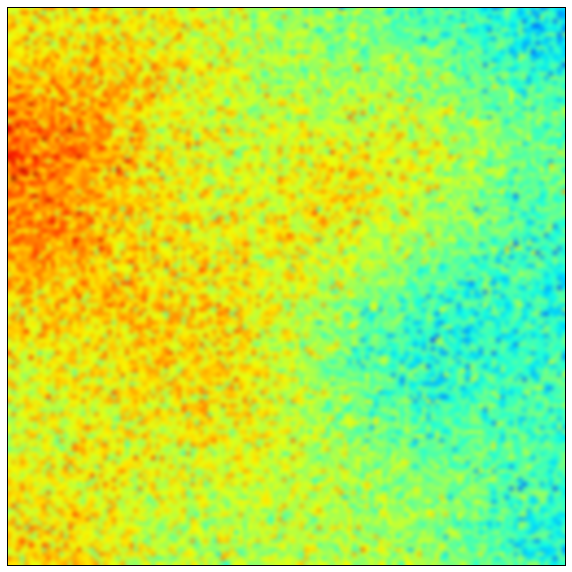

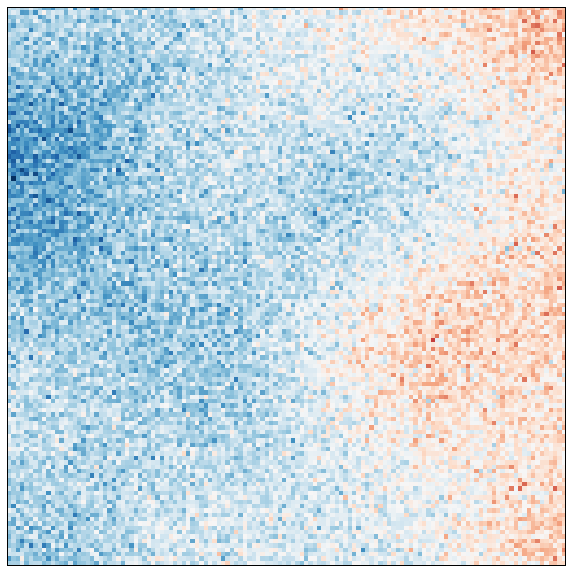

In [5]:
import scipy.ndimage as nd

shape = (128,128)
t = nd.gaussian_filter(np.random.randn(*shape), 20) + 0.01*np.random.randn(*shape)
r = np.abs(t).max()

fig = pl.figure(figsize=(10,10))
pl.imshow(t, interpolation='bicubic', cmap='jet', vmin=-r, vmax=r)
pl.xticks([])
pl.yticks([])
pl.grid('off')

fig = pl.figure(figsize=(10,10))
pl.imshow(t, interpolation='nearest', cmap='RdBu', vmin=-r, vmax=r)
pl.xticks([])
pl.yticks([])
pl.grid('off')